<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Свёрточная сеть отлично работает с тензорами, каждому тексту можно сопоставить вектор, то есть тензор первого ранга. Чтобы решить проблему с произвольной длинной входа, нужно научиться преобразовывать вектор произвольной длины в вектор фиксированной длины. Это может делать LSTM сеть, её скрытое состояние как раз учитывает весь вектор, у обученной сети оно запоминает достаточно, чтобы подавать его на вход свёрточной сети. 

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

В LSTM мы вводим контроллер памяти, то есть мы получаем возможность регулировать запоминание или забывание данных, в RNN такой возможности нет, поэтому данные могуть теряться при достаточно длинном векторе, наличие forget gate спасает от затухания или взрыва градиента.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?


**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

В обычном мы умножает очень много маленьких чисел, поэтому градиент затухает. В T версии умножаем меньше маленьких чисел, что помогает от описанной ранее проблемы.


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

image captioning, убираем у CNN последние несколько слоёв, представлением из нового последнего слоя инициализируем скрытое состояне RNN.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Слишком мало параметров (относительно размера словаря) - потеряем информацию, если взять слишком много - то не обучимся.

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-01 17:09:10--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/myvUYjAqAgqrmLae7mOs4sWUofrAUPcv9QR0EDqvMqUVt9Res4FIInqZR1k1Mja2/file?dl=1 [following]
--2017-05-01 17:09:11--  https://dl.dropboxusercontent.com/content_link/myvUYjAqAgqrmLae7mOs4sWUofrAUPcv9QR0EDqvMqUVt9Res4FIInqZR1k1Mja2/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482.77M  39.7MB/s    in 12s     

2017-05-01 17:09:24 (39.0 MB/s) - ‘data.tar.gz’ saved

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 3.92 s, sys: 1.19 s, total: 5.11 s
Wall time: 1min 55s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
from collections import Counter

In [5]:
all_descr = []
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        all_descr += captions[img_i][caption_i]

In [6]:
word_counts = Counter(all_descr)
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[234])

array([[ 8481,  4444,    11,   364,   326,  8717,  3952,  5324,     0,
         3981,  8134,    -1,    -1,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2171,  3974,  8717,  4444,  3952,  5324,   781,  3323,
          364,  8134,    -1,    -1,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  8039,     0,  5324,  3974,  5608,   781,  3323,
         4444,   364,  8134,    -1,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  8717,  4444,   364,   130,  8717,  5324,  8602,  7457,
         3952,  8680,  9738,  3011,  9752,  6643,  5470,  4589,  8134],
       [ 8481,  8717,   364,  3974, 10306,   326,  8717,  5324,   781,
         3976,  7730,  2951,  8134,    -1,    -1,    -1,    -1,    -1]], dtype=int32)

### Mah Neural Network

In [120]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 64 #pls change me if u want
LSTM_UNITS = 512 #pls change me if u want

In [10]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


In [197]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [198]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_sentence_embedding = EmbeddingLayer(l_words, input_size=len(vocab), output_size=EMBED_SIZE)

In [199]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small  = DropoutLayer(l_image_features, p=0.5)
l_image_features_small = DenseLayer(l_image_features_small, num_units=LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [200]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_sentence_embedding,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5.)

In [201]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 512)
output shape =  (None, None, 10373)


In [236]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = (loss * output_mask).mean()

In [248]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(T.grad(loss, weights), weights, learning_rate=0.0001)

In [249]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################

train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step = theano.function([image_vectors, sentences], loss)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [205]:
captions = np.array(captions)

In [250]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [207]:
generate_batch(img_codes,captions, 3)

(array([[-1.58613479, -3.24421763, -0.27480134, ..., -2.1146841 ,
          2.7940383 ,  1.2301414 ],
        [ 2.36792326,  0.762613  , -0.40160683, ...,  1.85563159,
          0.16925949,  0.38159257],
        [-3.65954494, -3.48561978, -0.20168951, ..., -1.73055482,
         -1.74715817,  1.01805341]], dtype=float32),
 array([[ 8481,  3715,  9600,  5432,  8717,  6332, 10224,  1558,   781,
         10139,  7083,   326,  4702,  8742,  8134,    -1],
        [ 8481,  8717,   998,   130,  7970,  1517,  7126,  8088,  8157,
          2595,   326,  8717,  9790,   781,  4364,  8134],
        [ 8481,  8717,  1019,  5609,  4859,  8717,  4556,  5324,   781,
          8717,  4817,  3221,  4426,  8134,    -1,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [241]:
batch_size = 20 #adjust me
n_epochs   = 1000 #adjust me
n_batches_per_epoch = 6164 #adjust me
n_validation_batches = 50 #how many batches are used for validation after each epoch

In [252]:
int(len(img_codes) / batch_size)

6164

In [210]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")


  0%|          | 11/6164 [00:00<05:33, 18.45it/s]

  0%|          | 3/6164 [00:00<04:57, 20.72it/s]/s]


Epoch: 0, train loss: 1.48895398364, val loss: 1.42500247598


  0%|          | 2/6164 [00:00<05:17, 19.39it/s]


Epoch: 1, train loss: 1.48190871623, val loss: 1.53540517926


 14%|█▍        | 865/6164 [00:47<04:36, 19.16it/s]

На самом деле модель обучалась конечно же не 2 эпохи, просто было дообучение после достаточно большого количества эпох.

### apply trained model

In [231]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [232]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

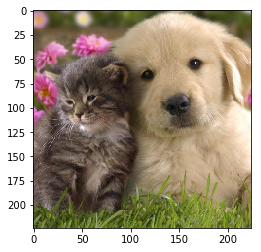

In [233]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [ ]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [247]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

the house is feeding the animals a small child eat some
a black and white kitten under a green barber cup in front of a cat
a game of two cats in the grass looking out the camera
a black and white cat enjoying a small face at the base of a field
a young girl eats a furry green hamster with a display around her
the cat is looking at the camera on the floor eating some sort of #UNK#
a haired man holding a small green #UNK# inserting into some type of milk
one with large black wedding kitten laying in a green stems of food
close up asleep on a beverage with a small girl is lying on the bench
roadside with green and white kitten with a clock on a holder


"a game of two cats in the grass looking out the camera" - звучит более менее разумно, хотя почему-то нейросеть приняла собаку за кошку.

# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 